##  1. Remove Rows Containing "frag" or "mutated" 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")

df_filtered = df[~df["Name"].astype(str).str.contains('frag|mutated|scrambled', case=False, na=False)]

print(df_filtered.tail())


                              Name     baseMean  log2FoldChange     lfcSE  \
11124   ZNF711|ENST00000674551.1|6  1088.305301       -0.309627  0.104404   
11125   ZNF711|ENST00000674551.1|7   795.485149       -0.757718  0.114540   
11126   ZNF711|ENST00000674551.1|8   973.872276        0.004969  0.144974   
11127   ZNF711|ENST00000674551.1|9  1578.271700       -1.620016  0.096323   
11128  ZNF711|ENST00000674551.1|10   625.090139       -3.526111  0.151224   

            stat         pvalue           padj  \
11124  -2.965671   3.020237e-03   3.851654e-03   
11125  -6.615334   3.707132e-11   6.911210e-11   
11126   0.034276   9.726573e-01   9.750991e-01   
11127 -16.818554   1.784604e-63   1.568566e-62   
11128 -23.317198  2.966981e-120  7.643964e-119   

                                  Seq  hek-gDNA1  hek-gDNA2  ...  hek-RNA2  \
11124  TGTTCAAGTTGATTGTTGTTCAGTATGGCA       1443       1344  ...       768   
11125  ATTTGAGAGAACACAGTTTTCTTAAATATT       1170       1028  ...       456   
11

## 2. Compute the Difference in log2FoldChange Between Adjacent Rows

In [31]:
# Extract gene name from "Name" column (before the first '|')
df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]

df_filtered['log2FC_adj_diff'] = abs(df_filtered.groupby("Gene")['log2FoldChange'].diff())
df_filtered.head()

/tmp/ipykernel_1296831/1211307110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]
/tmp/ipykernel_1296831/1211307110.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log2FC_adj_diff'] = abs(df_filtered.groupby("Gene")['log2FoldChange'].diff())


,Name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Seq,hek-gDNA1,hek-gDNA2,...,sk-gDNA1,sk-gDNA2,sk-gDNA3,sk-RNA1,sk-RNA2,sk-RNA3,aso-lib1,aso-lib2,Gene,log2FC_adj_diff
0,AAGAB|ENST00000261880.10|1,2659.245449,0.086427,0.106517,0.811394,4.171394e-01,4.454345e-01,ATTATTCATACTAGGGTTTGACCAACAAAG,2931,2511,...,3041,2212,1318,1660,1599,2036,3000,2635,AAGAB,NaN
1,AAGAB|ENST00000261880.10|2,2489.885932,0.511739,0.143115,3.575721,3.492642e-04,4.715106e-04,TTAGTTTTTAGTAGGAGGTTAAGGAGAAAT,2201,1890,...,3213,2573,1350,1891,1828,1708,3358,2859,AAGAB,0.425312
2,AAGAB|ENST00000261880.10|3,6038.426170,0.867749,0.072504,11.968271,5.210315e-33,2.027268e-32,TAAATCTCAGAGGTCTGTGTGATTTACTCA,4923,4555,...,6847,5955,6049,3490,3270,3675,7867,6851,AAGAB,0.356010
3,AAGAB|ENST00000261880.10|4,2022.130110,0.539307,0.119582,4.509938,6.484647e-06,9.592057e-06,ATTTGGGTTTTCTCCATTCAAGGAGCTTGT,1870,1612,...,2174,1716,1201,1500,1300,1170,2041,1822,AAGAB,0.328442
4,AAGAB|ENST00000261880.10|5,3272.032753,0.430862,0.092700,4.647896,3.353381e-06,5.036167e-06,GAAAATGCCTCTGGGCATTCTTTTGAAGTA,3262,2828,...,3404,2529,2081,2491,2280,2227,3110,2710,AAGAB,0.108445


## 3. Compute the Difference in log2FoldChange Between Two Random Rows

In [32]:
## Randomly pair all rows exactly once 
shuffled_df = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle rows
num_pairs = len(shuffled_df) // 2  # Get half the number of rows
random_pairs_all = [(shuffled_df.iloc[i]["log2FoldChange"], shuffled_df.iloc[i+1]["log2FoldChange"]) for i in range(0, len(shuffled_df)-1, 2)]
log2fc_diff_random_all = [abs(pair[0] - pair[1]) for pair in random_pairs_all]

In [33]:
len(log2fc_diff_random_all)

5323

## 4. Compute log2FoldChange Difference for Random Pairs Within the Same Gene

In [34]:
# Randomly pair rows within each gene (non-overlapping)
log2fc_diff_random_gene = []

for _, group in df_filtered.groupby("Gene"):
    shuffled_group = group.sample(frac=1, random_state=np.random.randint(0, 10000)).reset_index(drop=True)  # Shuffle rows within gene
    num_gene_pairs = len(shuffled_group) // 2  # Get half the number of rows in the group
    if num_gene_pairs > 0:
        gene_pairs = [(shuffled_group.iloc[i]["log2FoldChange"], shuffled_group.iloc[i+1]["log2FoldChange"]) for i in range(0, len(shuffled_group)-1, 2)]
        log2fc_diff_random_gene.extend([abs(pair[0] - pair[1]) for pair in gene_pairs])

print(len(log2fc_diff_random_gene))

5141


In [35]:
print(df_filtered.head())

                         Name     baseMean  log2FoldChange     lfcSE  \
0  AAGAB|ENST00000261880.10|1  2659.245449        0.086427  0.106517   
1  AAGAB|ENST00000261880.10|2  2489.885932        0.511739  0.143115   
2  AAGAB|ENST00000261880.10|3  6038.426170        0.867749  0.072504   
3  AAGAB|ENST00000261880.10|4  2022.130110        0.539307  0.119582   
4  AAGAB|ENST00000261880.10|5  3272.032753        0.430862  0.092700   

        stat        pvalue          padj                             Seq  \
0   0.811394  4.171394e-01  4.454345e-01  ATTATTCATACTAGGGTTTGACCAACAAAG   
1   3.575721  3.492642e-04  4.715106e-04  TTAGTTTTTAGTAGGAGGTTAAGGAGAAAT   
2  11.968271  5.210315e-33  2.027268e-32  TAAATCTCAGAGGTCTGTGTGATTTACTCA   
3   4.509938  6.484647e-06  9.592057e-06  ATTTGGGTTTTCTCCATTCAAGGAGCTTGT   
4   4.647896  3.353381e-06  5.036167e-06  GAAAATGCCTCTGGGCATTCTTTTGAAGTA   

   hek-gDNA1  hek-gDNA2  ...  sk-gDNA1  sk-gDNA2  sk-gDNA3  sk-RNA1  sk-RNA2  \
0       2931       2511  ...  

## Draw cedf plot 

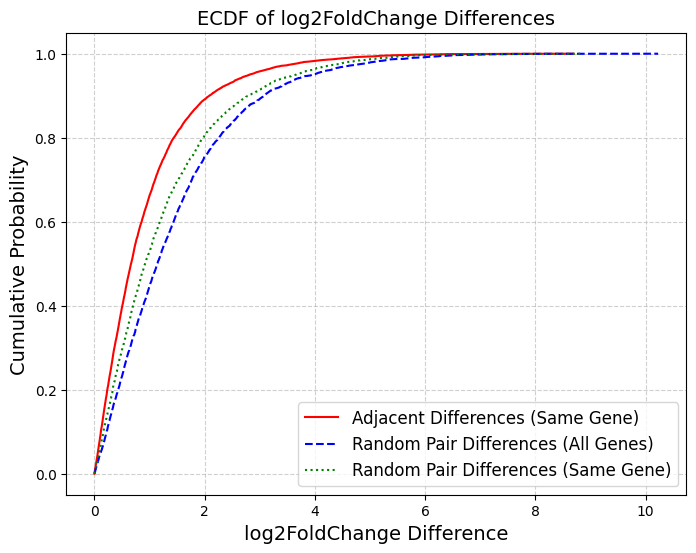

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute the empirical CDF
def empirical_cdf(data):
    sorted_data = np.sort(data)
    y_vals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, y_vals

# Compute CDF values for each group
x_adj, y_adj = empirical_cdf(df_filtered["log2FC_adj_diff"].dropna().values)
x_random_all, y_random_all = empirical_cdf(np.array(log2fc_diff_random_all))
x_random_gene, y_random_gene = empirical_cdf(np.array(log2fc_diff_random_gene))

# Plot the CDFs
plt.figure(figsize=(8, 6))
plt.plot(x_adj, y_adj, label="Adjacent Differences (Same Gene)", linestyle="-", color="red")
plt.plot(x_random_all, y_random_all, label="Random Pair Differences (All Genes)", linestyle="--", color="blue")
plt.plot(x_random_gene, y_random_gene, label="Random Pair Differences (Same Gene)", linestyle=":", color="green")

# Formatting the plot
plt.xlabel("log2FoldChange Difference", fontsize=14)
plt.ylabel("Cumulative Probability", fontsize=14)
plt.title("ECDF of log2FoldChange Differences", fontsize=14)
plt.legend( fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Define a function to compute the empirical CDF
def empirical_cdf(data):
    sorted_data = np.sort(data)
    y_vals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, y_vals

# Compute CDF values for each group
x_adj, y_adj = empirical_cdf(df_filtered["log2FC_adj_diff"].dropna().values)
x_random_all, y_random_all = empirical_cdf(np.array(log2fc_diff_random_all))
x_random_gene, y_random_gene = empirical_cdf(np.array(log2fc_diff_random_gene))

# Perform KS test between the groups
ks_adj_random_all = ks_2samp(df_filtered["log2FC_adj_diff"].dropna().values, log2fc_diff_random_all)
ks_adj_random_gene = ks_2samp(df_filtered["log2FC_adj_diff"].dropna().values, log2fc_diff_random_gene)
ks_random_all_random_gene = ks_2samp(log2fc_diff_random_all, log2fc_diff_random_gene)

print(f"KS Adj vs Random All: D={ks_adj_random_all.statistic:.3f}, p={ks_adj_random_all.pvalue:.3e}")
print(f"KS Adj vs Random Gene: D={ks_adj_random_gene.statistic:.3f}, p={ks_adj_random_gene.pvalue:.3e}")
print(f"KS Random All vs Random Gene: D={ks_random_all_random_gene.statistic:.3f}, p={ks_random_all_random_gene.pvalue:.3e}")

# Show the plot
plt.show()


KS Adj vs Random All: D=0.217, p=3.158e-144
KS Adj vs Random Gene: D=0.135, p=3.131e-54
KS Random All vs Random Gene: D=0.090, p=9.062e-19


/tmp/ipykernel_1296831/4110494355.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]
/tmp/ipykernel_1296831/4110494355.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')


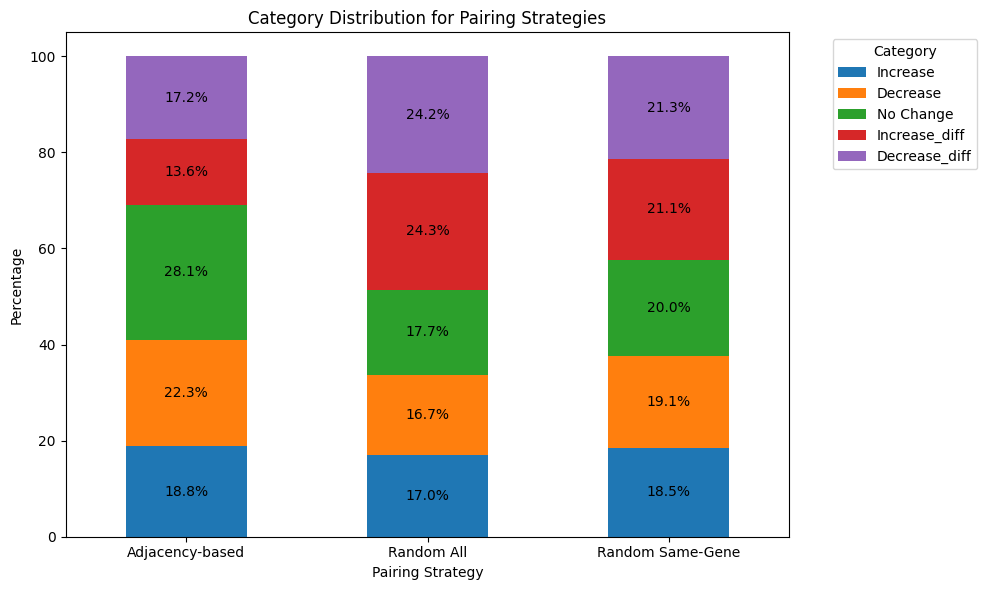

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Data
df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_sk_df100.csv")

# Clean data: Remove 'frag', 'mutated', 'scrambled'
df_filtered = df[~df["Name"].astype(str).str.contains('frag|mutated|scrambled', case=False, na=False)]

# Extract gene name
df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]

# Step 2: Compute log2FC direction
df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')

# ================================
# ** Step 3a: Adjacency-based Pairing (Same Gene) **
# ================================
adjacency_pairs = []
adjacency_pairs_direction = []

for gene, group in df_filtered.groupby("Gene"):
    if len(group) > 1:
        if len(group) % 2 != 0:
            group = group.iloc[1:]  # Remove first row if odd
        
        for i in range(0, len(group)-1, 2):
            val1, val2 = group.iloc[i]["log2FoldChange"], group.iloc[i+1]["log2FoldChange"]
            diff = val2 - val1  # Signed difference
            direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'
            
            adjacency_pairs.append(diff)
            adjacency_pairs_direction.append(direction)

adjacency_pairs_df = pd.DataFrame({
    'log2FC_adj_diff': adjacency_pairs,
    'log2FC_direction': adjacency_pairs_direction
})

# ================================
# ** Step 3b: Random Pairing Across All Genes (Pairs Exactly Once) **
# ================================
shuffled_df = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle rows

num_pairs = len(shuffled_df) // 2  # Determine the number of complete pairs
shuffled_df = shuffled_df.iloc[:num_pairs * 2]  # Ensure an even number of rows (leave out one if odd)

random_pairs_all = []
random_pairs_direction_all = []

for i in range(0, len(shuffled_df) - 1, 2):  # Iterate in steps of 2
    val1, val2 = shuffled_df.iloc[i]["log2FoldChange"], shuffled_df.iloc[i + 1]["log2FoldChange"]
    diff = val2 - val1  # Signed difference
    direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'

    random_pairs_all.append(diff)
    random_pairs_direction_all.append(direction)

random_pairs_all_df = pd.DataFrame({
    'log2FC_adj_diff': random_pairs_all,
    'log2FC_direction': random_pairs_direction_all
})


# ================================
# ** Step 3c: Random Pairing Within the Same Gene **
# ================================
random_pairs_same_gene = []
random_pairs_direction_same_gene = []

for gene, group in df_filtered.groupby("Gene"):
    shuffled_group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    
    if len(shuffled_group) > 1:
        if len(shuffled_group) % 2 != 0:
            shuffled_group = shuffled_group.iloc[1:]  # Remove first row if odd
        
        for i in range(0, len(shuffled_group)-1, 2):
            val1, val2 = shuffled_group.iloc[i]["log2FoldChange"], shuffled_group.iloc[i+1]["log2FoldChange"]
            diff = val2 - val1
            direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'

            random_pairs_same_gene.append(diff)
            random_pairs_direction_same_gene.append(direction)

random_pairs_same_gene_df = pd.DataFrame({
    'log2FC_adj_diff': random_pairs_same_gene,
    'log2FC_direction': random_pairs_direction_same_gene
})

# ================================
# ** Step 4: Categorization Function **
# ================================
def categorize_diff(log2fc_diff, direction):
    if -0.5 <= log2fc_diff <= 0.5:
        return "No Change"
    
    if direction == "same" 
        return "Increase" if direction == "same" else "Increase_diff"
    
    if log2fc_diff < -0.5:
        return "Decrease" if direction == "same" else "Decrease_diff"
    
    return "Unknown"

# Apply categorization
adjacency_pairs_df['Category'] = adjacency_pairs_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)
random_pairs_all_df['Category'] = random_pairs_all_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)
random_pairs_same_gene_df['Category'] = random_pairs_same_gene_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)

# ================================
# ** Step 5: Calculate Percentage of Categories **
# ================================
def calculate_category_percentages(df):
    category_counts = df['Category'].value_counts(normalize=True) * 100
    all_categories = ['Increase', 'Decrease', 'No Change', 'Increase_diff', 'Decrease_diff']
    for category in all_categories:
        if category not in category_counts:
            category_counts[category] = 0
    return category_counts[all_categories]

adjacency_percentage = calculate_category_percentages(adjacency_pairs_df)
random_all_percentage = calculate_category_percentages(random_pairs_all_df)
random_same_gene_percentage = calculate_category_percentages(random_pairs_same_gene_df)

# ================================
# ** Step 6: Prepare Data for Plotting **
# ================================
plot_data = pd.DataFrame({
    'Increase': [adjacency_percentage['Increase'], random_all_percentage['Increase'], random_same_gene_percentage['Increase']],
    'Decrease': [adjacency_percentage['Decrease'], random_all_percentage['Decrease'], random_same_gene_percentage['Decrease']],
    'No Change': [adjacency_percentage['No Change'], random_all_percentage['No Change'], random_same_gene_percentage['No Change']],
    'Increase_diff': [adjacency_percentage['Increase_diff'], random_all_percentage['Increase_diff'], random_same_gene_percentage['Increase_diff']],
    'Decrease_diff': [adjacency_percentage['Decrease_diff'], random_all_percentage['Decrease_diff'], random_same_gene_percentage['Decrease_diff']]
}, index=['Adjacency-based', 'Random All', 'Random Same-Gene'])

# Remove 0% categories
plot_data = plot_data.loc[:, (plot_data != 0).any(axis=0)]

# ================================
# ** Step 7: Plot Results **
# ================================
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Category Distribution for Pairing Strategies')
plt.xlabel('Pairing Strategy')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only label bars with a non-zero height
        # Place label in the middle of the bar (vertically)
        ax.annotate(f'{height:.1f}%', 
                    xy=(p.get_x() + p.get_width() / 2., p.get_y() + height / 2), 
                    ha='center', va='center', fontsize=10)

# Show plot
plt.show()

/tmp/ipykernel_3797067/3790462848.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]
/tmp/ipykernel_3797067/3790462848.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')


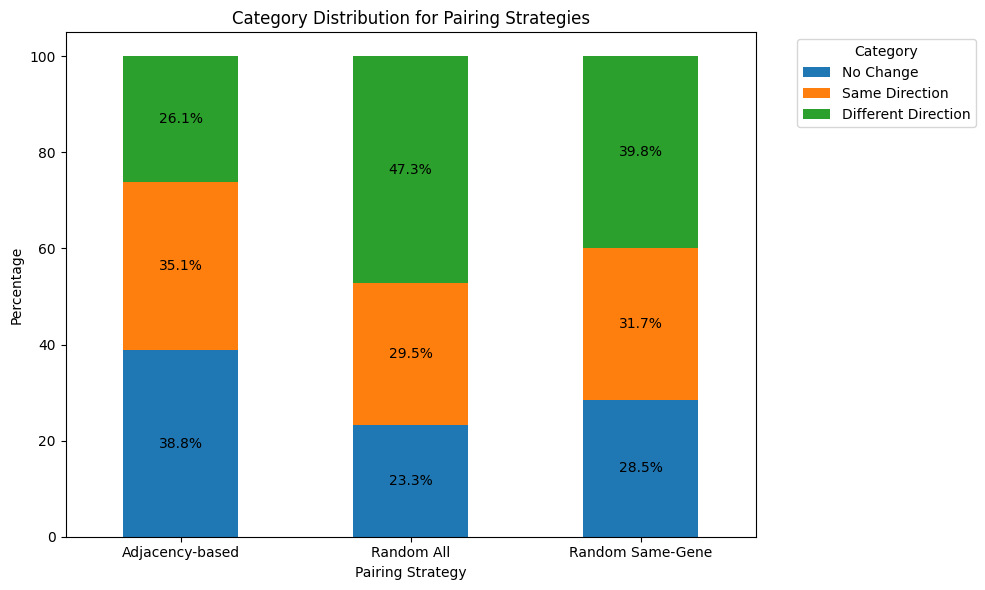

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Data
df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")

# Clean data: Remove 'frag', 'mutated', 'scrambled'
df_filtered = df[~df["Name"].astype(str).str.contains('frag|mutated|scrambled', case=False, na=False)]

# Extract gene name
df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]

# Compute log2FC direction
df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')

# Function to create log2FC pairs
def create_pairs(df, pairing_type="adjacency"):
    pairs = []
    directions = []
    
    if pairing_type == "adjacency":
        grouped = df.groupby("Gene")
    elif pairing_type == "random_all":
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        grouped = [("all", df)]
    elif pairing_type == "random_same_gene":
        grouped = [(gene, group.sample(frac=1, random_state=42).reset_index(drop=True)) for gene, group in df.groupby("Gene")]
    
    for _, group in grouped:
        if len(group) > 1:
            if len(group) % 2 != 0:
                group = group.iloc[1:]
            
            for i in range(0, len(group) - 1, 2):
                val1, val2 = group.iloc[i]["log2FoldChange"], group.iloc[i + 1]["log2FoldChange"]
                diff = val2 - val1
                direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'
                
                pairs.append(diff)
                directions.append(direction)
    
    return pd.DataFrame({
        'log2FC_adj_diff': pairs,
        'log2FC_direction': directions
    })

# Create datasets
adjacency_pairs_df = create_pairs(df_filtered, "adjacency")
random_pairs_all_df = create_pairs(df_filtered, "random_all")
random_pairs_same_gene_df = create_pairs(df_filtered, "random_same_gene")

# Categorization function
def categorize_diff(log2fc_diff, direction):
    if -0.5 <= log2fc_diff <= 0.5:
        return "No Change"
    else:
        return "Same Direction" if direction == "same" else "Different Direction"

# Apply categorization
for df in [adjacency_pairs_df, random_pairs_all_df, random_pairs_same_gene_df]:
    df['Category'] = df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)

# Calculate percentages
def calculate_category_percentages(df):
    return df['Category'].value_counts(normalize=True) * 100

adjacency_percentage = calculate_category_percentages(adjacency_pairs_df)
random_all_percentage = calculate_category_percentages(random_pairs_all_df)
random_same_gene_percentage = calculate_category_percentages(random_pairs_same_gene_df)

# Prepare Data for Plotting
plot_data = pd.DataFrame({
    'No Change': [adjacency_percentage.get('No Change', 0), random_all_percentage.get('No Change', 0), random_same_gene_percentage.get('No Change', 0)],
    'Same Direction': [adjacency_percentage.get('Same Direction', 0), random_all_percentage.get('Same Direction', 0), random_same_gene_percentage.get('Same Direction', 0)],
    'Different Direction': [adjacency_percentage.get('Different Direction', 0), random_all_percentage.get('Different Direction', 0), random_same_gene_percentage.get('Different Direction', 0)]
}, index=['Adjacency-based', 'Random All', 'Random Same-Gene'])

# Plot Results
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Category Distribution for Pairing Strategies')
plt.xlabel('Pairing Strategy')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only label bars with a non-zero height
        # Place label in the middle of the bar (vertically)
        ax.annotate(f'{height:.1f}%', 
                    xy=(p.get_x() + p.get_width() / 2., p.get_y() + height / 2), 
                    ha='center', va='center', fontsize=10)

# Show plot
plt.show()


/tmp/ipykernel_3797067/1572896056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]
/tmp/ipykernel_3797067/1572896056.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')


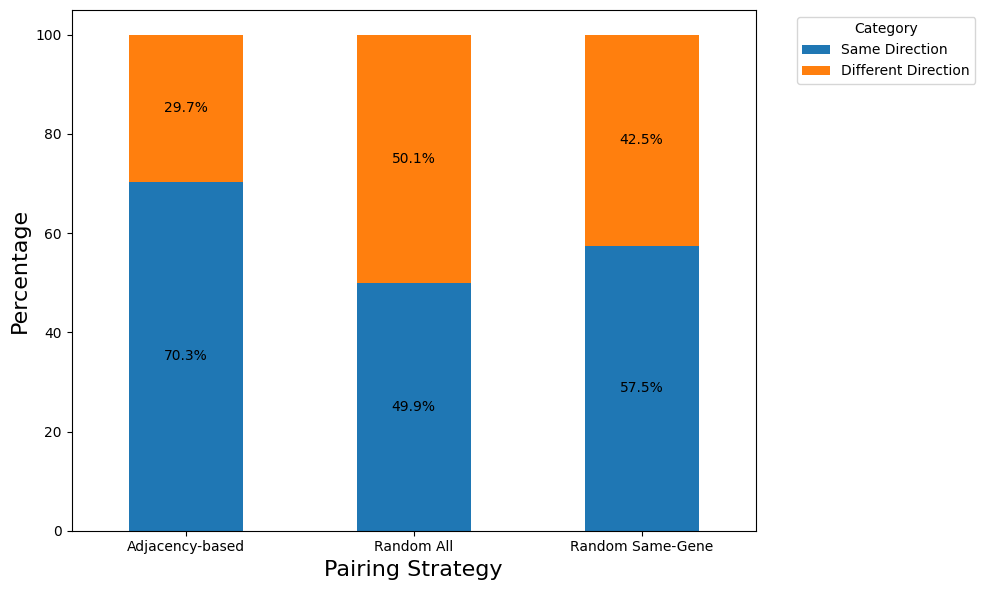

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Data
df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")

# Clean data: Remove 'frag', 'mutated', 'scrambled'
df_filtered = df[~df["Name"].astype(str).str.contains('frag|mutated|scrambled', case=False, na=False)]

# Extract gene name
df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]

# Compute log2FC direction
df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')

# Function to create log2FC pairs
def create_pairs(df, pairing_type="adjacency"):
    pairs = []
    directions = []
    
    if pairing_type == "adjacency":
        grouped = df.groupby("Gene")
    elif pairing_type == "random_all":
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        grouped = [("all", df)]
    elif pairing_type == "random_same_gene":
        grouped = [(gene, group.sample(frac=1, random_state=42).reset_index(drop=True)) for gene, group in df.groupby("Gene")]
    
    for _, group in grouped:
        if len(group) > 1:
            if len(group) % 2 != 0:
                group = group.iloc[1:]
            
            for i in range(0, len(group) - 1, 2):
                val1, val2 = group.iloc[i]["log2FoldChange"], group.iloc[i + 1]["log2FoldChange"]
                diff = val2 - val1
                direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'
                
                pairs.append(diff)
                directions.append(direction)
    
    return pd.DataFrame({
        'log2FC_adj_diff': pairs,
        'log2FC_direction': directions
    })

# Create datasets
adjacency_pairs_df = create_pairs(df_filtered, "adjacency")
random_pairs_all_df = create_pairs(df_filtered, "random_all")
random_pairs_same_gene_df = create_pairs(df_filtered, "random_same_gene")

# Categorization function
def categorize_diff(log2fc_diff, direction):
    return "Same Direction" if direction == "same" else "Different Direction"

# Apply categorization
for df in [adjacency_pairs_df, random_pairs_all_df, random_pairs_same_gene_df]:
    df['Category'] = df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)

# Calculate percentages
def calculate_category_percentages(df):
    return df['Category'].value_counts(normalize=True) * 100

adjacency_percentage = calculate_category_percentages(adjacency_pairs_df)
random_all_percentage = calculate_category_percentages(random_pairs_all_df)
random_same_gene_percentage = calculate_category_percentages(random_pairs_same_gene_df)

# Prepare Data for Plotting
plot_data = pd.DataFrame({ 
    'Same Direction': [adjacency_percentage.get('Same Direction', 0), random_all_percentage.get('Same Direction', 0), random_same_gene_percentage.get('Same Direction', 0)],
    'Different Direction': [adjacency_percentage.get('Different Direction', 0), random_all_percentage.get('Different Direction', 0), random_same_gene_percentage.get('Different Direction', 0)]
}, index=['Adjacency-based', 'Random All', 'Random Same-Gene'])

# Plot Results
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Pairing Strategy', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.xticks(rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only label bars with a non-zero height
        # Place label in the middle of the bar (vertically)
        ax.annotate(f'{height:.1f}%', 
                    xy=(p.get_x() + p.get_width() / 2., p.get_y() + height / 2), 
                    ha='center', va='center', fontsize=10)

# Show plot
plt.show()


/tmp/ipykernel_1296831/1918974929.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]
/tmp/ipykernel_1296831/1918974929.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')


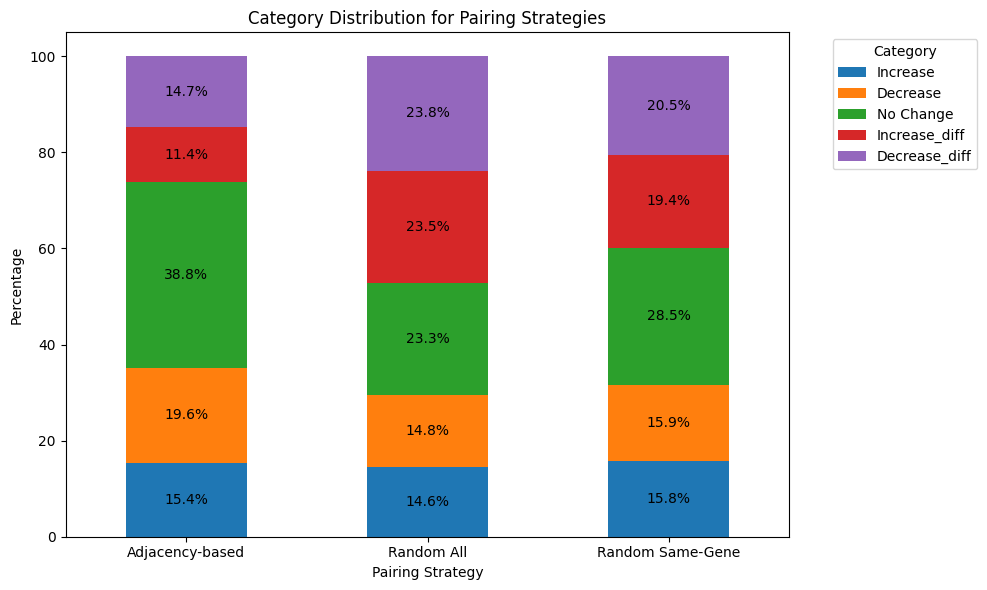

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Data
df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")

# Clean data: Remove 'frag', 'mutated', 'scrambled'
df_filtered = df[~df["Name"].astype(str).str.contains('frag|mutated|scrambled', case=False, na=False)]

# Extract gene name
df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]

# Step 2: Compute log2FC direction
df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')

# ================================
# ** Step 3a: Adjacency-based Pairing (Same Gene) **
# ================================
adjacency_pairs = []
adjacency_pairs_direction = []

for gene, group in df_filtered.groupby("Gene"):
    if len(group) > 1:
        if len(group) % 2 != 0:
            group = group.iloc[1:]  # Remove first row if odd
        
        for i in range(0, len(group)-1, 2):
            val1, val2 = group.iloc[i]["log2FoldChange"], group.iloc[i+1]["log2FoldChange"]
            diff = val2 - val1  # Signed difference
            direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'
            
            adjacency_pairs.append(diff)
            adjacency_pairs_direction.append(direction)

adjacency_pairs_df = pd.DataFrame({
    'log2FC_adj_diff': adjacency_pairs,
    'log2FC_direction': adjacency_pairs_direction
})

# ================================
# ** Step 3b: Random Pairing Across All Genes (Pairs Exactly Once) **
# ================================
shuffled_df = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle rows

num_pairs = len(shuffled_df) // 2  # Determine the number of complete pairs
shuffled_df = shuffled_df.iloc[:num_pairs * 2]  # Ensure an even number of rows (leave out one if odd)

random_pairs_all = []
random_pairs_direction_all = []

for i in range(0, len(shuffled_df) - 1, 2):  # Iterate in steps of 2
    val1, val2 = shuffled_df.iloc[i]["log2FoldChange"], shuffled_df.iloc[i + 1]["log2FoldChange"]
    diff = val2 - val1  # Signed difference
    direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'

    random_pairs_all.append(diff)
    random_pairs_direction_all.append(direction)

random_pairs_all_df = pd.DataFrame({
    'log2FC_adj_diff': random_pairs_all,
    'log2FC_direction': random_pairs_direction_all
})


# ================================
# ** Step 3c: Random Pairing Within the Same Gene **
# ================================
random_pairs_same_gene = []
random_pairs_direction_same_gene = []

for gene, group in df_filtered.groupby("Gene"):
    shuffled_group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    
    if len(shuffled_group) > 1:
        if len(shuffled_group) % 2 != 0:
            shuffled_group = shuffled_group.iloc[1:]  # Remove first row if odd
        
        for i in range(0, len(shuffled_group)-1, 2):
            val1, val2 = shuffled_group.iloc[i]["log2FoldChange"], shuffled_group.iloc[i+1]["log2FoldChange"]
            diff = val2 - val1
            direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'

            random_pairs_same_gene.append(diff)
            random_pairs_direction_same_gene.append(direction)

random_pairs_same_gene_df = pd.DataFrame({
    'log2FC_adj_diff': random_pairs_same_gene,
    'log2FC_direction': random_pairs_direction_same_gene
})

# ================================
# ** Step 4: Categorization Function **
# ================================
def categorize_diff(log2fc_diff, direction):
    if -0.5 <= log2fc_diff <= 0.5:
        return "No Change"
    
    if log2fc_diff > 0.5:
        return "Increase" if direction == "same" else "Increase_diff"
    
    if log2fc_diff < -0.5:
        return "Decrease" if direction == "same" else "Decrease_diff"
    
    return "Unknown"

# Apply categorization
adjacency_pairs_df['Category'] = adjacency_pairs_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)
random_pairs_all_df['Category'] = random_pairs_all_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)
random_pairs_same_gene_df['Category'] = random_pairs_same_gene_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)

# ================================
# ** Step 5: Calculate Percentage of Categories **
# ================================
def calculate_category_percentages(df):
    category_counts = df['Category'].value_counts(normalize=True) * 100
    all_categories = ['Increase', 'Decrease', 'No Change', 'Increase_diff', 'Decrease_diff']
    for category in all_categories:
        if category not in category_counts:
            category_counts[category] = 0
    return category_counts[all_categories]

adjacency_percentage = calculate_category_percentages(adjacency_pairs_df)
random_all_percentage = calculate_category_percentages(random_pairs_all_df)
random_same_gene_percentage = calculate_category_percentages(random_pairs_same_gene_df)

# ================================
# ** Step 6: Prepare Data for Plotting **
# ================================
plot_data = pd.DataFrame({
    'Increase': [adjacency_percentage['Increase'], random_all_percentage['Increase'], random_same_gene_percentage['Increase']],
    'Decrease': [adjacency_percentage['Decrease'], random_all_percentage['Decrease'], random_same_gene_percentage['Decrease']],
    'No Change': [adjacency_percentage['No Change'], random_all_percentage['No Change'], random_same_gene_percentage['No Change']],
    'Increase_diff': [adjacency_percentage['Increase_diff'], random_all_percentage['Increase_diff'], random_same_gene_percentage['Increase_diff']],
    'Decrease_diff': [adjacency_percentage['Decrease_diff'], random_all_percentage['Decrease_diff'], random_same_gene_percentage['Decrease_diff']]
}, index=['Adjacency-based', 'Random All', 'Random Same-Gene'])

# Remove 0% categories
plot_data = plot_data.loc[:, (plot_data != 0).any(axis=0)]

# ================================
# ** Step 7: Plot Results **
# ================================
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Category Distribution for Pairing Strategies')
plt.xlabel('Pairing Strategy')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only label bars with a non-zero height
        # Place label in the middle of the bar (vertically)
        ax.annotate(f'{height:.1f}%', 
                    xy=(p.get_x() + p.get_width() / 2., p.get_y() + height / 2), 
                    ha='center', va='center', fontsize=10)

# Show plot
plt.show()

/tmp/ipykernel_4182271/738998345.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]
/tmp/ipykernel_4182271/738998345.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')


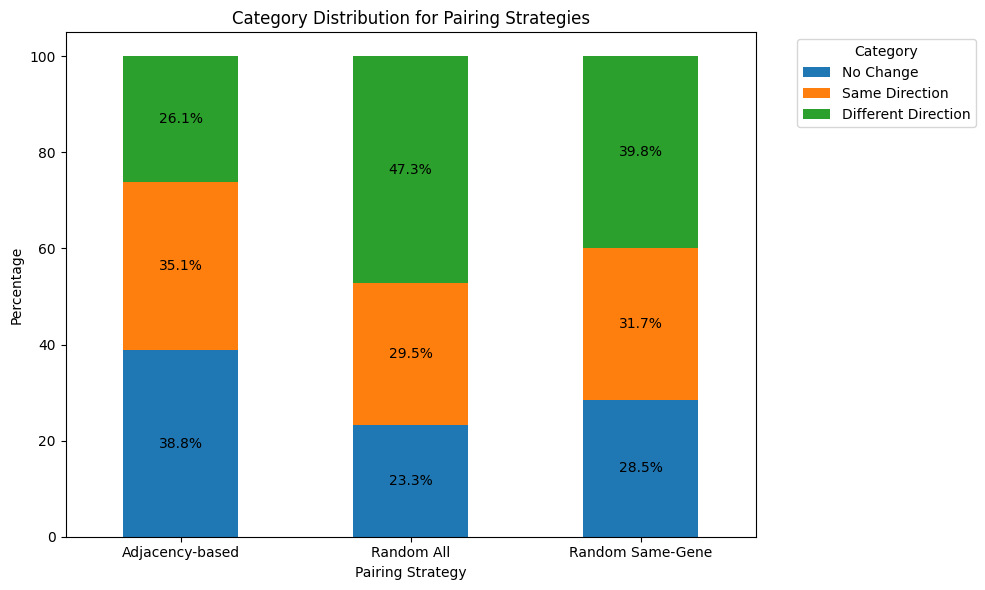

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Data
df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")

# Clean data: Remove 'frag', 'mutated', 'scrambled'
df_filtered = df[~df["Name"].astype(str).str.contains('frag|mutated|scrambled', case=False, na=False)]

# Extract gene name
df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]

# Compute log2FC direction
df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')

# Function to create log2FC pairs
def create_pairs(df, pairing_type="adjacency"):
    pairs = []
    directions = []
    
    if pairing_type == "adjacency":
        grouped = df.groupby("Gene")
    elif pairing_type == "random_all":
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        grouped = [("all", df)]
    elif pairing_type == "random_same_gene":
        grouped = [(gene, group.sample(frac=1, random_state=42).reset_index(drop=True)) for gene, group in df.groupby("Gene")]
    
    for _, group in grouped:
        if len(group) > 1:
            if len(group) % 2 != 0:
                group = group.iloc[1:]
            
            for i in range(0, len(group) - 1, 2):
                val1, val2 = group.iloc[i]["log2FoldChange"], group.iloc[i + 1]["log2FoldChange"]
                diff = val2 - val1
                direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'
                
                pairs.append(diff)
                directions.append(direction)
    
    return pd.DataFrame({
        'log2FC_adj_diff': pairs,
        'log2FC_direction': directions
    })

# Create datasets
adjacency_pairs_df = create_pairs(df_filtered, "adjacency")
random_pairs_all_df = create_pairs(df_filtered, "random_all")
random_pairs_same_gene_df = create_pairs(df_filtered, "random_same_gene")

# Categorization function
def categorize_diff(log2fc_diff, direction):
    if -0.5 <= log2fc_diff <= 0.5:
        return "No Change"
    else:
        return "Same Direction" if direction == "same" else "Different Direction"

# Apply categorization
for df in [adjacency_pairs_df, random_pairs_all_df, random_pairs_same_gene_df]:
    df['Category'] = df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)

# Calculate percentages
def calculate_category_percentages(df):
    return df['Category'].value_counts(normalize=True) * 100

adjacency_percentage = calculate_category_percentages(adjacency_pairs_df)
random_all_percentage = calculate_category_percentages(random_pairs_all_df)
random_same_gene_percentage = calculate_category_percentages(random_pairs_same_gene_df)

# Prepare Data for Plotting
plot_data = pd.DataFrame({
    'No Change': [adjacency_percentage.get('No Change', 0), random_all_percentage.get('No Change', 0), random_same_gene_percentage.get('No Change', 0)],
    'Same Direction': [adjacency_percentage.get('Same Direction', 0), random_all_percentage.get('Same Direction', 0), random_same_gene_percentage.get('Same Direction', 0)],
    'Different Direction': [adjacency_percentage.get('Different Direction', 0), random_all_percentage.get('Different Direction', 0), random_same_gene_percentage.get('Different Direction', 0)]
}, index=['Adjacency-based', 'Random All', 'Random Same-Gene'])

# Plot Results
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Category Distribution for Pairing Strategies')
plt.xlabel('Pairing Strategy')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only label bars with a non-zero height
        # Place label in the middle of the bar (vertically)
        ax.annotate(f'{height:.1f}%', 
                    xy=(p.get_x() + p.get_width() / 2., p.get_y() + height / 2), 
                    ha='center', va='center', fontsize=10)

# Show plot
plt.show()

/tmp/ipykernel_1296831/1704701658.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]
/tmp/ipykernel_1296831/1704701658.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')


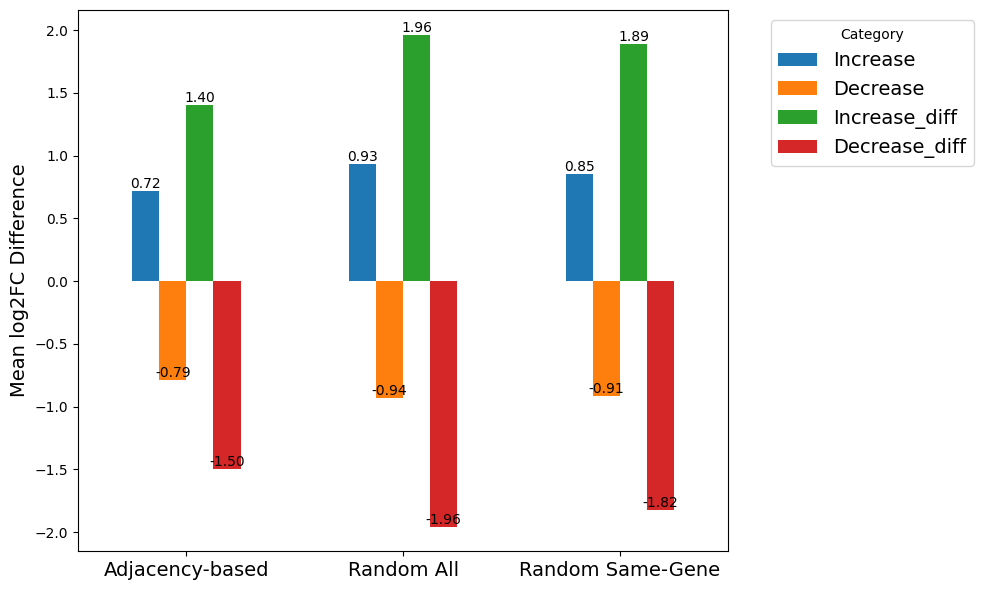

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Data
df = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")

# Clean data: Remove 'frag', 'mutated', 'scrambled'
df_filtered = df[~df["Name"].astype(str).str.contains('frag|mutated|scrambled', case=False, na=False)]

# Extract gene name
df_filtered["Gene"] = df_filtered["Name"].str.split("|").str[0]

# Step 2: Compute log2FC direction
df_filtered['log2FC_direction'] = df_filtered['log2FoldChange'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')

# ================================
# ** Step 3a: Adjacency-based Pairing (Same Gene) **
# ================================
adjacency_pairs = []
adjacency_pairs_direction = []

for gene, group in df_filtered.groupby("Gene"):
    if len(group) > 1:
        if len(group) % 2 != 0:
            group = group.iloc[1:]  # Remove first row if odd
        
        for i in range(0, len(group)-1, 2):
            val1, val2 = group.iloc[i]["log2FoldChange"], group.iloc[i+1]["log2FoldChange"]
            diff = val2 - val1  # Signed difference
            direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'
            
            adjacency_pairs.append(diff)
            adjacency_pairs_direction.append(direction)

adjacency_pairs_df = pd.DataFrame({
    'log2FC_adj_diff': adjacency_pairs,
    'log2FC_direction': adjacency_pairs_direction
})

# ================================
# ** Step 3b: Random Pairing Across All Genes (Pairs Exactly Once) **
# ================================
shuffled_df = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle rows

num_pairs = len(shuffled_df) // 2  # Determine the number of complete pairs
shuffled_df = shuffled_df.iloc[:num_pairs * 2]  # Ensure an even number of rows (leave out one if odd)

random_pairs_all = []
random_pairs_direction_all = []

for i in range(0, len(shuffled_df) - 1, 2):  # Iterate in steps of 2
    val1, val2 = shuffled_df.iloc[i]["log2FoldChange"], shuffled_df.iloc[i + 1]["log2FoldChange"]
    diff = val2 - val1  # Signed difference
    direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'

    random_pairs_all.append(diff)
    random_pairs_direction_all.append(direction)

random_pairs_all_df = pd.DataFrame({
    'log2FC_adj_diff': random_pairs_all,
    'log2FC_direction': random_pairs_direction_all
})


# ================================
# ** Step 3c: Random Pairing Within the Same Gene **
# ================================
random_pairs_same_gene = []
random_pairs_direction_same_gene = []

for gene, group in df_filtered.groupby("Gene"):
    shuffled_group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    
    if len(shuffled_group) > 1:
        if len(shuffled_group) % 2 != 0:
            shuffled_group = shuffled_group.iloc[1:]  # Remove first row if odd
        
        for i in range(0, len(shuffled_group)-1, 2):
            val1, val2 = shuffled_group.iloc[i]["log2FoldChange"], shuffled_group.iloc[i+1]["log2FoldChange"]
            diff = val2 - val1
            direction = 'same' if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0) else 'dif'

            random_pairs_same_gene.append(diff)
            random_pairs_direction_same_gene.append(direction)

random_pairs_same_gene_df = pd.DataFrame({
    'log2FC_adj_diff': random_pairs_same_gene,
    'log2FC_direction': random_pairs_direction_same_gene
})

# ================================
# ** Step 4: Categorization Function **
# ================================
def categorize_diff(log2fc_diff, direction):
    # if -0.5 <= log2fc_diff <= 0.5:
    #     return "No Change"
    
    if log2fc_diff > 0:
        return "Increase" if direction == "same" else "Increase_diff"
    
    if log2fc_diff < 0:
        return "Decrease" if direction == "same" else "Decrease_diff"
    
    return "Unknown"

# Apply categorization
adjacency_pairs_df['Category'] = adjacency_pairs_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)
random_pairs_all_df['Category'] = random_pairs_all_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)
random_pairs_same_gene_df['Category'] = random_pairs_same_gene_df.apply(lambda row: categorize_diff(row['log2FC_adj_diff'], row['log2FC_direction']), axis=1)


# ================================
# ** Step 5: Calculate Mean Difference of Categories **
# ================================
def calculate_category_means(df):
    category_means = df.groupby('Category')['log2FC_adj_diff'].mean()
    
    # Ensure all categories are present
    all_categories = ['Increase', 'Decrease', 'No Change', 'Increase_diff', 'Decrease_diff']
    for category in all_categories:
        if category not in category_means:
            category_means[category] = 0  # Assign 0 if the category is missing
    
    return category_means[all_categories]

adjacency_mean_diff = calculate_category_means(adjacency_pairs_df)
random_all_mean_diff = calculate_category_means(random_pairs_all_df)
random_same_gene_mean_diff = calculate_category_means(random_pairs_same_gene_df)

# ================================
# ** Step 6: Prepare Data for Plotting **
# ================================
plot_data = pd.DataFrame({
    'Increase': [adjacency_mean_diff['Increase'], random_all_mean_diff['Increase'], random_same_gene_mean_diff['Increase']],
    'Decrease': [adjacency_mean_diff['Decrease'], random_all_mean_diff['Decrease'], random_same_gene_mean_diff['Decrease']],
    'No Change': [adjacency_mean_diff['No Change'], random_all_mean_diff['No Change'], random_same_gene_mean_diff['No Change']],
    'Increase_diff': [adjacency_mean_diff['Increase_diff'], random_all_mean_diff['Increase_diff'], random_same_gene_mean_diff['Increase_diff']],
    'Decrease_diff': [adjacency_mean_diff['Decrease_diff'], random_all_mean_diff['Decrease_diff'], random_same_gene_mean_diff['Decrease_diff']]
}, index=['Adjacency-based', 'Random All', 'Random Same-Gene'])

# Remove 0 categories (not present)
plot_data = plot_data.loc[:, (plot_data != 0).any(axis=0)]

# ================================
# ** Step 7: Plot Results **
# ================================
ax = plot_data.plot(kind='bar', figsize=(10,6))
# plt.title('Mean Difference for Pairing Strategies')
# plt.xlabel('Pairing Strategy', fontsize=14)
plt.ylabel('Mean log2FC Difference', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=14)
plt.tight_layout()

# Add mean value labels on bars
for p in ax.patches:
    height = p.get_height()
    if height != 0:  # Only label bars with non-zero values
        ax.annotate(f'{height:.2f}', 
                    xy=(p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10)

# Show plot
plt.show()
